# Assignment InfoVision


As a part of the selection process, please complete the following assignment.

Assignment Title: Natural Language Processing for Sentiment Analysis


Assignment Objectives:
In this assignment, you will be required to build a sentiment analysis model using Natural Language Processing (NLP) techniques. Sentiment analysis, also known as opinion mining, is critical in many AI applications, including customer feedback analysis, social media monitoring, and more. Your task is to create a sentiment analysis model to accurately classify text data into positive, negative, or neutral sentiments.

Assignment Instructions:
1.	Data Collection: You are provided with a dataset containing text data from various sources (e.g.,product reviews, social media comments, news articles). The dataset is divided into two categories: positive sentiment and negative sentiment. Download the dataset [provide a link to the dataset].
2.	Data Pre-processing: Clean and preprocess the text data to prepare it for model training. This may include tasks such as tokenization, stemming, and removing stop words.
3.	Model Selection: Choose an appropriate NLP model for sentiment analysis. You can use pre-trained models like BERT, GPT-3, or train your own model using libraries like TensorFlow or PyTorch.
4.	Model Training: Train your selected model on the preprocessed data. Split the dataset into training and testing sets to evaluate the model's performance accurately.
5.	Evaluation: Assess the performance of your sentiment analysis model using appropriate evaluation metrics (e.g., accuracy, precision, recall, F1-score). Provide a detailed analysis of the model's strengths and weaknesses.
6.	Deployment: If possible, deploy your model as a web service or API to demonstrate its real-world usability. Include instructions on how to interact with the deployed model.
7.	Documentation: Create a detailed report that includes the following:
a.	Data pre-processing steps.
b.	Model architecture and parameters.
c.	Training process and hyperparameters.
d.	Evaluation results and analysis.
e.	Instructions for using the deployed model (if applicable).

Submission Guidelines:
1.	Submit your assignment as a comprehensive report, including code, documentation, and any necessary instructions for evaluation.
2.	Include a link to your code repository (e.g., GitHub) for review.
3.	Ensure that your code is well-organized, commented, and follows best practices.


Grading Criteria:
Your assignment will be evaluated based on the following criteria:
•	Data pre-processing (15%)
•	Model selection and architecture (20%)
•	Model training and performance (20%)
•	Deployment (if applicable) (10%)
•	Documentation and report quality (15%)
•	Code organization and best practices (10%)
•	Overall analysis and insights (10%)

Note: Plagiarism is strictly prohibited. Any use of external sources or code must be properly cited. This assignment aims to assess your technical skills, problem-solving abilities, and your capacity to work on a practical AI project. We appreciate your effort and look forward to reviewing your submission. If you have any questions or require clarification, please feel free to reach out to us. Good luck!


## Import all necessary libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
import warnings

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# visualization settings
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Data Exploration

In [4]:
df = pd.read_csv("hate.csv")

In [5]:
df_new = df[['id', 'comment', 'label']]

In [6]:
df_new.head()

,id,comment,label
0,1,dalits are lowlives,N
1,2,gay people are a burden to our society,N
2,3,Arabs are not welcome,N
3,4,I'm not saying we should actually eliminate he...,N
4,5,bananas are for black people,N


In [7]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41144 entries, 0 to 41143
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       41144 non-null  int64 
 1   comment  41144 non-null  object
 2   label    41144 non-null  object
dtypes: int64(1), object(2)
memory usage: 964.4+ KB


In [8]:
df_new.label.value_counts()

label
N    22158
P    18950
O       36
Name: count, dtype: int64

## Data pre-processing

In [9]:
possible_labels = df_new.label.unique()

In [10]:
len(possible_labels)

3

In [11]:
possible_labels

array(['N', 'P', 'O'], dtype=object)

In [12]:
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

In [13]:
label_dict

{'N': 0, 'P': 1, 'O': 2}

In [14]:
df_new.label = df_new['label'].map(label_dict)

In [15]:
df_new.head()

,id,comment,label
0,1,dalits are lowlives,0
1,2,gay people are a burden to our society,0
2,3,Arabs are not welcome,0
3,4,I'm not saying we should actually eliminate he...,0
4,5,bananas are for black people,0


In [16]:
df_new.label.value_counts()

label
0    22158
1    18950
2       36
Name: count, dtype: int64

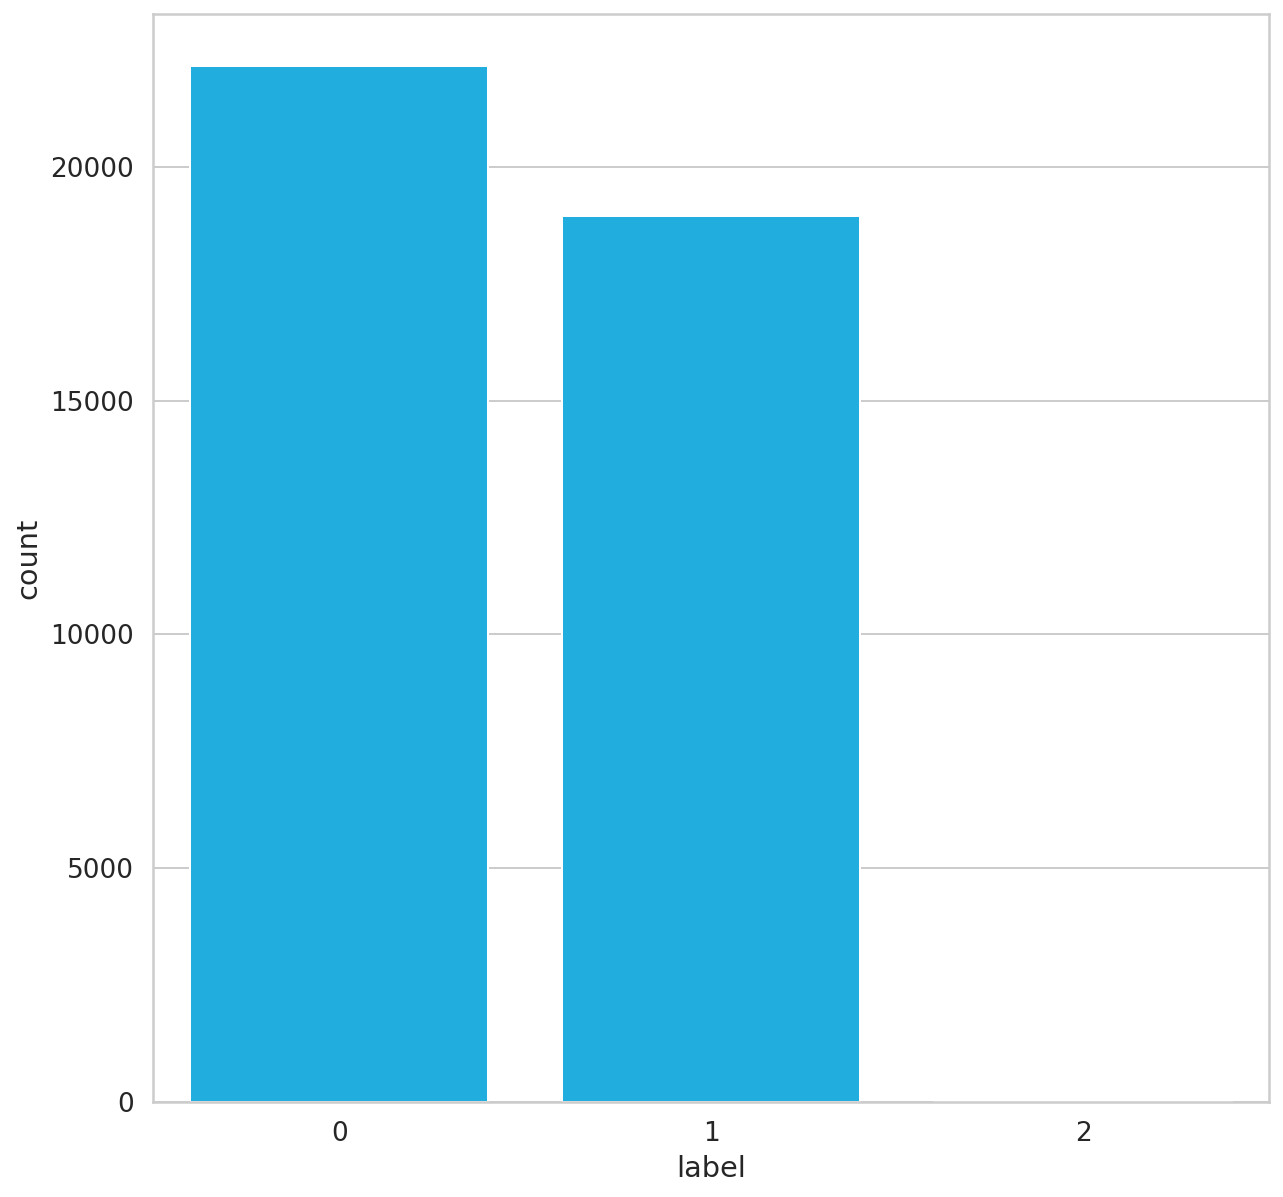

In [17]:
# create a plot of categories in label
plt.figure(figsize=(10, 10))
sns.countplot(x="label", data=df_new)
plt.show()

In [18]:
df_new[df_new['label'] == 2]

,id,comment,label
2680,2716,"My teacher is Chinese and he is awful, no surp...",2
2929,2965,"Imagine having a trans sibling??,N""",2
2930,2966,"Imagine having no siblings??,P""",2
3079,3115,This area is Asian-predominant just to let you...,2
3948,3987,"things were great and then covid arrived, and ...",2
5240,5279,he yelled about women being shit or something....,2
5768,5807,"I wish heshes didn't bother me anymore, but th...",2
7642,7686,You??e disabled if you identify as a transgend...,2
9704,9750,"Young towns, villages and now they have moved ...",2
10027,10074,I had a few issues choosing office colours for...,2


### Removing other category as 36 values seem insignificant infont of negatives and positives

In [19]:
df_new = df_new[df_new['label'] != 2]

In [20]:
df_new.label.value_counts()

label
0    22158
1    18950
Name: count, dtype: int64

### Create two classes

In [21]:
class_names = ['negative', 'positive']

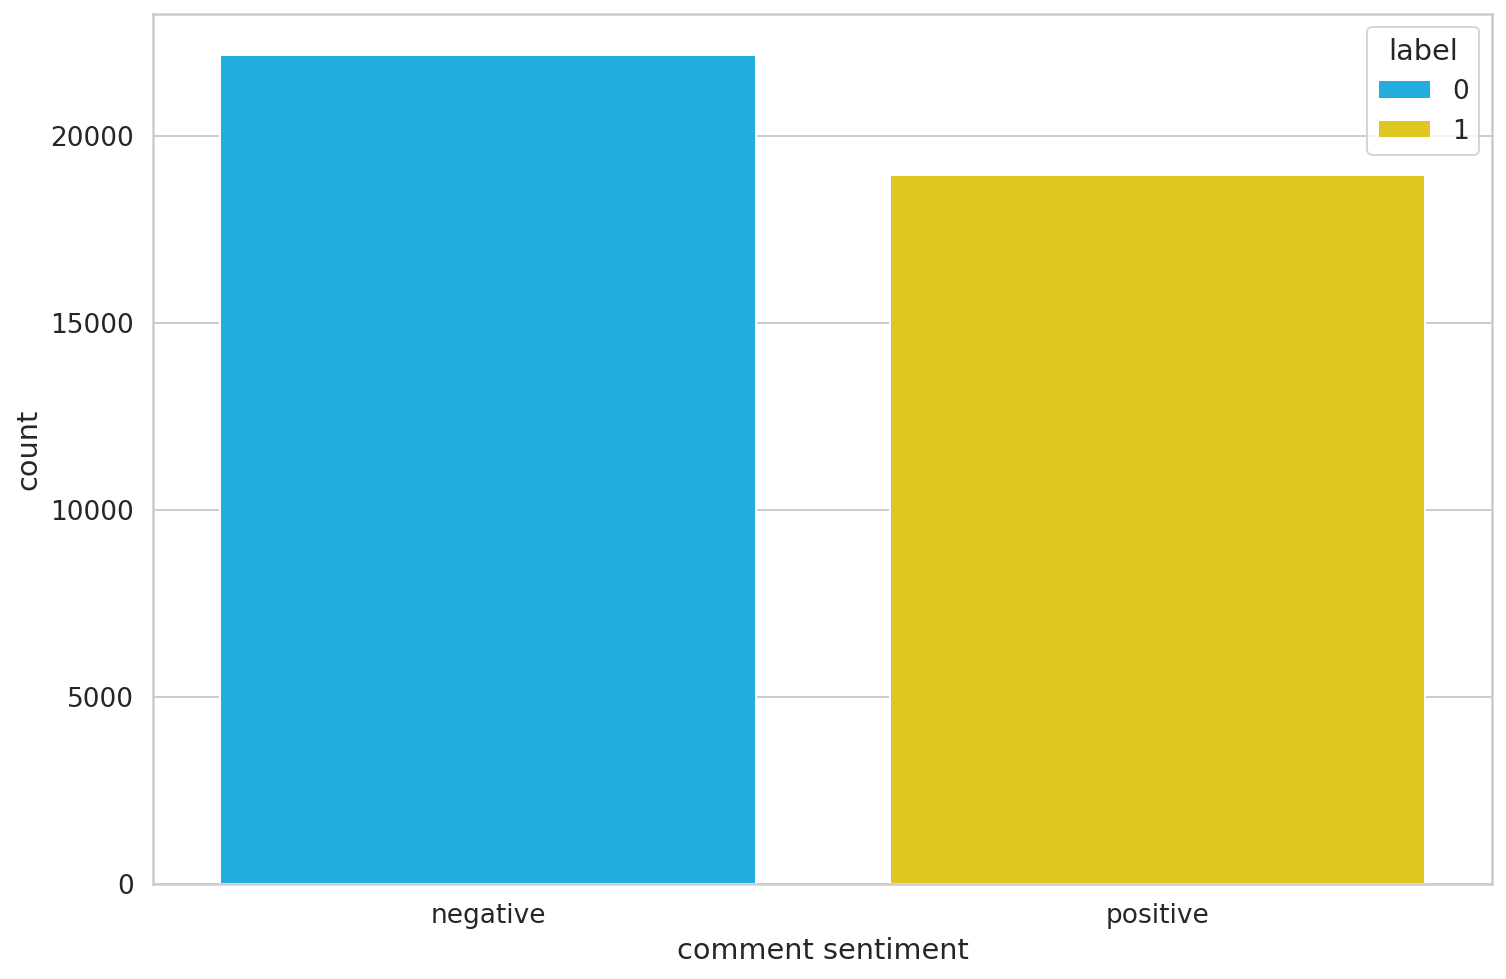

In [22]:
ax = sns.countplot(data=df_new, x="label", hue='label', dodge=False)
plt.xlabel('comment sentiment')
ax.set_xticklabels(class_names);

### Shuffle the rows in dataset

In [23]:
df_new = df_new.sample(frac=1).reset_index(drop=True)

In [24]:
df_new.head()

,id,comment,label
0,8977,"dear all blllllllaaaaackkkkks , go hoooooooome",0
1,25815,Beaners is a horrific name some people use for...,1
2,30720,i've been secretely a lesbian for over 20 year...,1
3,12697,"The police, never forget, take their orders fr...",0
4,2028,what bellends! this country has turned into an...,1


In [25]:
df_new['label'] = df_new['label'].astype(int)

BERT doesn't work with raw text. Need to pre-process the data:

- Add special tokens to separate sentences and do classification
- Pass sequences of constant length (introduce padding)
- Create array of 0s (pad token) and 1s (real token) called *attention mask*

In [26]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [27]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

### Checking tokens for an example

In [87]:
sample_txt = 'what is wrong in the world, why is this happening'

In [88]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: what is wrong in the world, why is this happening
   Tokens: ['what', 'is', 'wrong', 'in', 'the', 'world', ',', 'why', 'is', 'this', 'happening']
Token IDs: [1184, 1110, 2488, 1107, 1103, 1362, 117, 1725, 1110, 1142, 5664]


In [89]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  truncation=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [90]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 1184, 1110, 2488, 1107, 1103, 1362,  117, 1725, 1110, 1142, 5664,
         102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [91]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [92]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'what',
 'is',
 'wrong',
 'in',
 'the',
 'world',
 ',',
 'why',
 'is',
 'this',
 'happening',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

### Choosing sequence length

In [93]:
token_lens = []

for txt in df_new.comment:
  tokens_s = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens_s))

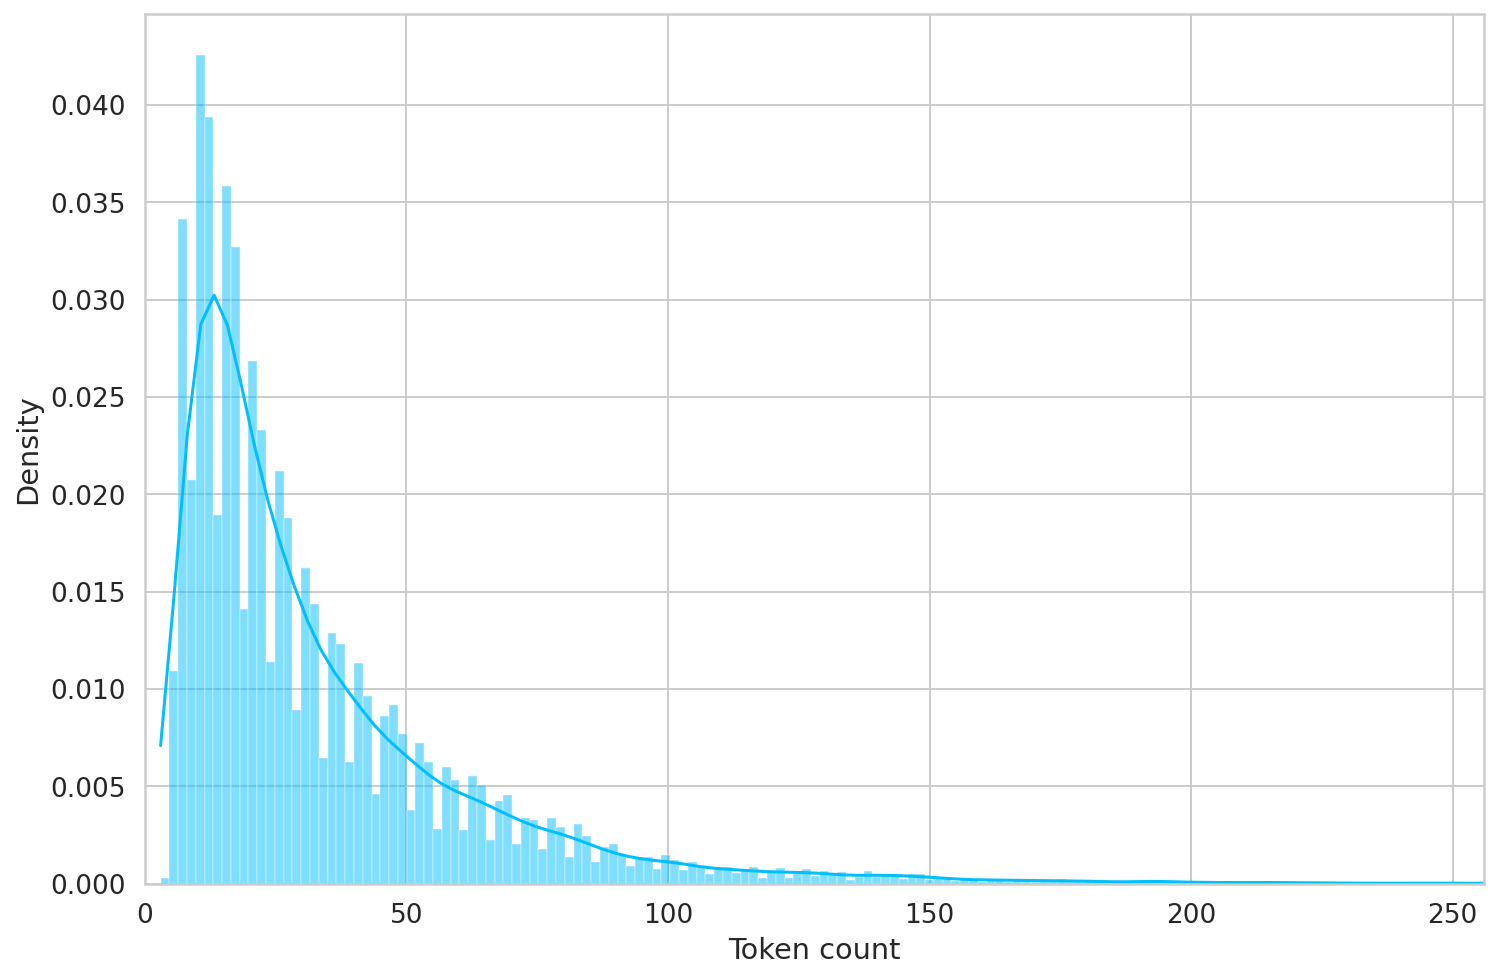

In [94]:
sns.histplot(token_lens, kde=True, stat="density")
plt.xlim([0, 256]);
plt.xlabel('Token count');

Most of the comments contain less than 150 tokens, will tkae 160 to be on safer side.

In [95]:
MAX_LEN = 160

### Creating a wrapper for dataset creation for BERT

In [96]:
class InfoVisionDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

### Splitting dataset into train

In [97]:
df_train, df_test = train_test_split(df_new, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [98]:
df_train.shape, df_val.shape, df_test.shape

((36997, 3), (2055, 3), (2056, 3))

Creating data loader

In [40]:
def create_data_loader(df_input, tokenizer, max_len, batch_size):
  ds = InfoVisionDataset(
    reviews=df_input.comment.to_numpy(),
    targets=df_input.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [41]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Checking next batch

In [42]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [43]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


## Sentiment classification using BERT

In [44]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [45]:
outputs = bert_model(encoding['input_ids'], encoding['attention_mask'])

In [46]:
outputs[0].shape

torch.Size([1, 32, 768])

In [47]:
outputs[1].shape

torch.Size([1, 768])

In [48]:
bert_model.config.hidden_size

768

In [49]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    outputs = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(outputs[1])
    return self.out(output)

In [50]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [51]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 160])
torch.Size([16, 160])


In [52]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.3264, 0.6736],
        [0.4755, 0.5245],
        [0.5612, 0.4388],
        [0.3615, 0.6385],
        [0.7775, 0.2225],
        [0.3499, 0.6501],
        [0.5297, 0.4703],
        [0.6448, 0.3552],
        [0.6301, 0.3699],
        [0.6086, 0.3914],
        [0.6573, 0.3427],
        [0.6733, 0.3267],
        [0.3460, 0.6540],
        [0.5818, 0.4182],
        [0.6331, 0.3669],
        [0.2985, 0.7015]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

### Training

In [53]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [54]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

    #correct_predictions_per_example=correct_predictions.double() / n_examples

  return correct_predictions.double() / n_examples, np.mean(losses)

In [55]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

      #correct_predictions_per_example=correct_predictions.double() / n_examples

  return correct_predictions.double() / n_examples, np.mean(losses)

In [56]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.5044403187076972 accuracy 0.7414925534502798
Val   loss 0.4156667418027109 accuracy 0.7951338199513382

Epoch 2/10
----------
Train loss 0.3186838421700832 accuracy 0.8559342649404005
Val   loss 0.4913193024983702 accuracy 0.7868613138686131

Epoch 3/10
----------
Train loss 0.22154225531214156 accuracy 0.9122361272535611
Val   loss 0.7303802371313868 accuracy 0.7790754257907543

Epoch 4/10
----------
Train loss 0.17213413526934562 accuracy 0.9422385598832337
Val   loss 1.0651169367019058 accuracy 0.7873479318734794

Epoch 5/10
----------
Train loss 0.13604569438014913 accuracy 0.9612941589858637
Val   loss 1.1610507143249864 accuracy 0.7771289537712895

Epoch 6/10
----------
Train loss 0.10684776684392984 accuracy 0.9725383139173446
Val   loss 1.3442298527337726 accuracy 0.7766423357664234

Epoch 7/10
----------
Train loss 0.08206816803605095 accuracy 0.9803227288699083
Val   loss 1.445688524149907 accuracy 0.7766423357664234

Epoch 8/10
----------
T

In [62]:
history_values = {
    "train_acc":[],
    "val_acc":[]
    }
for tac in history['train_acc']:
    history_values['train_acc'].append(tac.item())
for vac in history['val_acc']:
    history_values['val_acc'].append(vac.item())

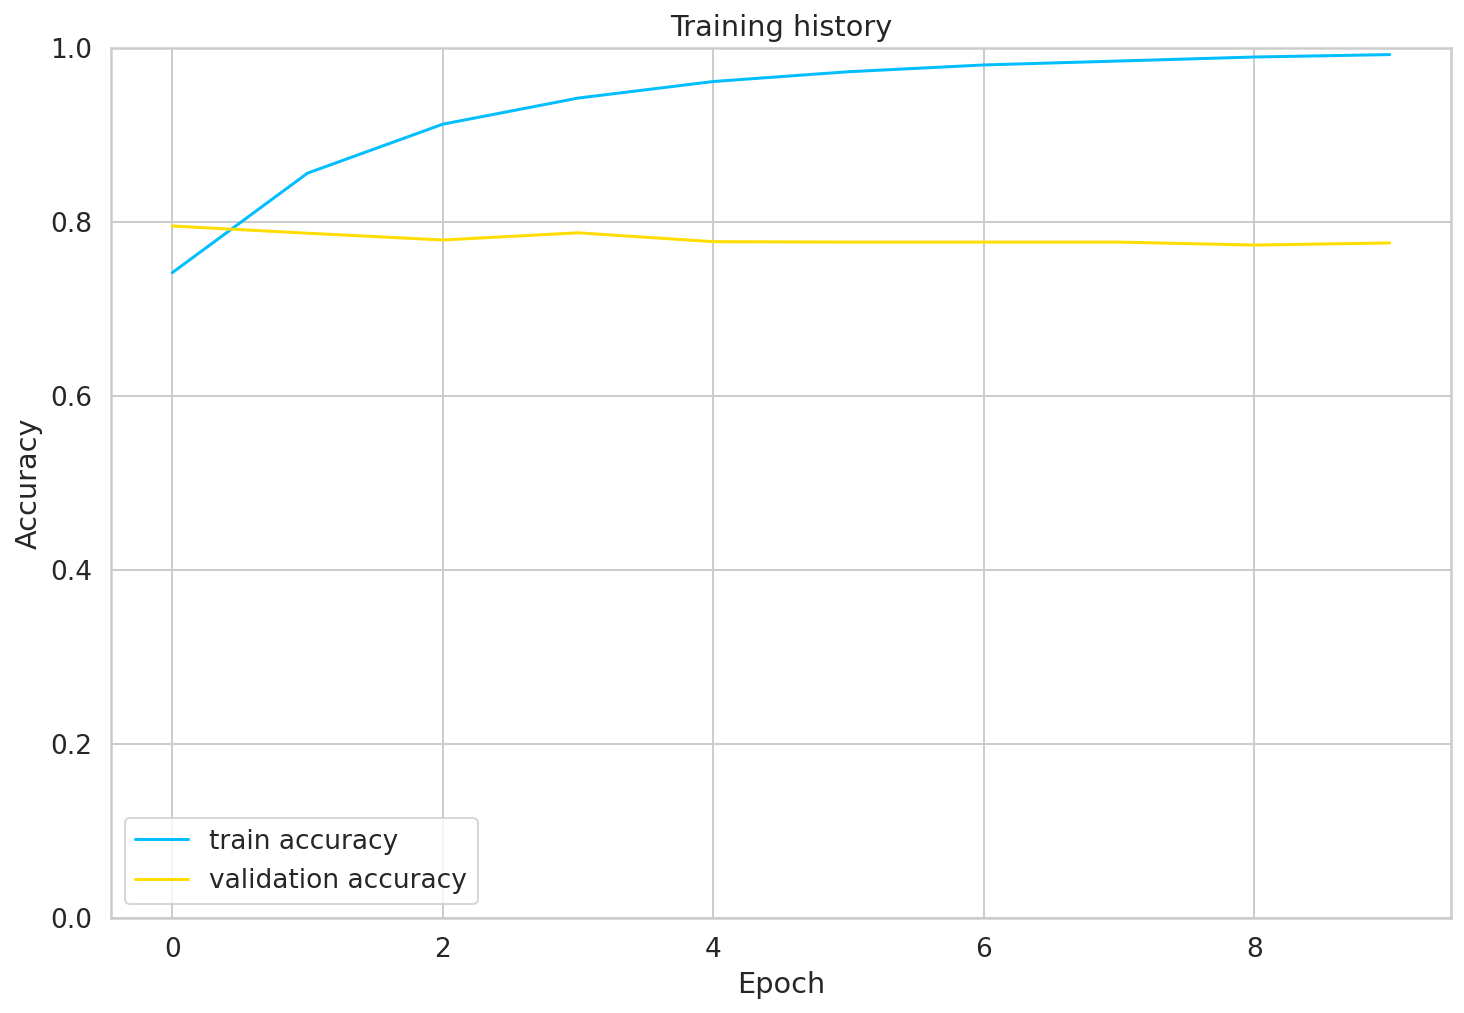

In [64]:
plt.plot(history_values['train_acc'], label='train accuracy')
plt.plot(history_values['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [65]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.7932879377431906

In [66]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [67]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [68]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.81      0.81      0.81      1117
    positive       0.77      0.77      0.77       939

    accuracy                           0.79      2056
   macro avg       0.79      0.79      0.79      2056
weighted avg       0.79      0.79      0.79      2056



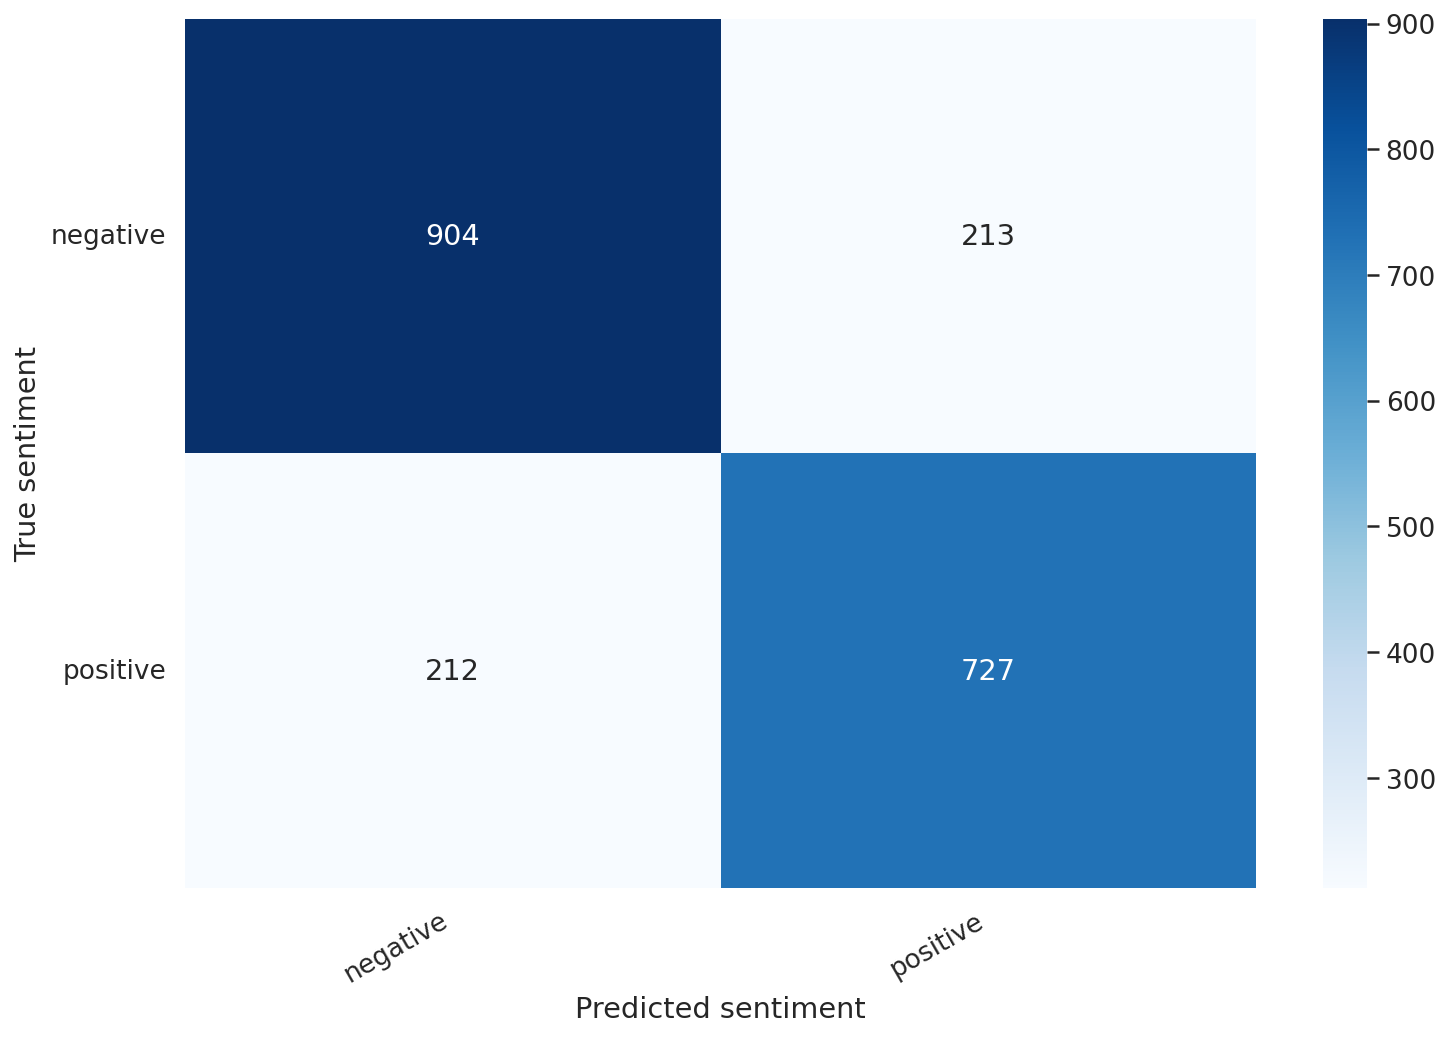

In [69]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [70]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [71]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

Someone wrote nazis didn't kill any Jews. But they mostly died from
Typhus and starvation because Americans and Brits bombed the shit of
out the place and delivering supplies to the camps became extremely
difficult. Can you imagine being that ignorant?

True sentiment: positive


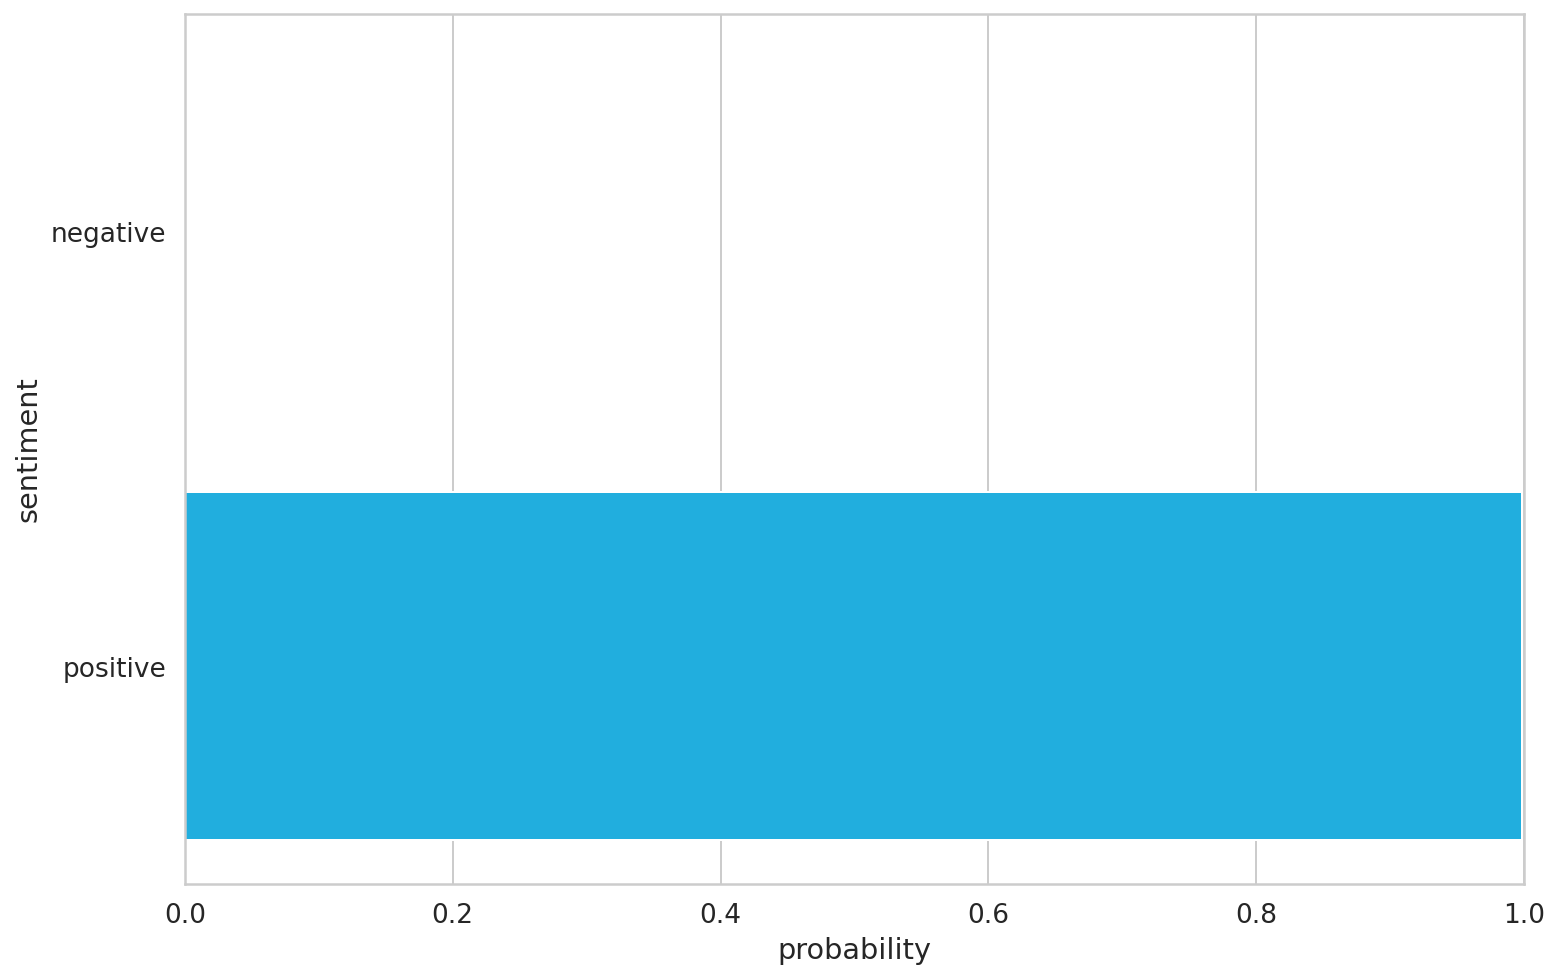

In [72]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

## Testing on Raw Text

In [73]:
review_text = "I liked doing this assignmnet for InfoVision!"

In [74]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [75]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I liked doing this assignmnet for InfoVision!
Sentiment  : positive
